# This notebook will take a qp,qc screen generated from StabilityScreen_CS3390.jl and generate corresponding heatmaps

In [140]:
using Pkg
Pkg.add("Clustering")
Pkg.add("MAT")
Pkg.add("PyCall")
Pkg.add("DelimitedFiles")

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
  [8bb1440f] + DelimitedFiles 
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [143]:
using SharedArrays
using Distributed
using Random
using JLD
using StatsBase
using Statistics
using Clustering
using MAT
using DelimitedFiles
import PyPlot; const plt = PyPlot;

In [137]:
function mypickle(filename, obj)
    out = open(filename,"w")
    pickle1.dump(obj, out)
    close(out)
 end

mypickle (generic function with 1 method)

In [147]:
writedlm("CMPs.csv", Array(CMPs), ",")

### Change the line below to load in the correct jld save


In [145]:
d1 = load("../src/nGen_200_nCellType_20_nMediator_15_ri0_0.2_posIntRatio_0.9_at_1_bt_0.1_qp_0.85_qc_0.1_multistability_seed_1588387517_510ddf09c9a7453cb54248f061e66d7a.jld")

Dict{String,Any} with 2 entries:
  "CMPs"   => [0.0 0.0 … 0.0 0.0; 0.0191462 0.0191463 … 0.0191473 0.0191466; … …
  "params" => Dict{String,Any}("nInitialCell"=>10000.0,"qp"=>0.85,"bt"=>0.1,"de…

In [146]:
CMPs = d1["CMPs"]
nSamples = d1["params"]["nSample"]

function BrayCurtisComposition(a::T, b::T) where {T<:Array{<:AbstractFloat,1}}
    return 1 - sum(map(min, a, b))
end

BrayCurtisComposition (generic function with 1 method)

In [31]:
bcs = zeros(nSamples, nSamples)

for j = 1:nSamples, i = 1:nSamples
    a = CMPs[:, i]
    b = CMPs[:, j]
    bcs[i,j] = BrayCurtisComposition(a, b)
end

In [98]:
dt = fit(ZScoreTransform, bcs, dims=1)
j = SharedArray(StatsBase.transform(dt, bcs))

500×500 SharedArray{Float64,2}:
 -1.01182   -0.352579   -0.618522  …  -0.361715    1.11596     1.13899
 -0.545953  -0.893496   -0.688515     -0.809421    0.490227    0.418353
 -0.746258  -0.660921   -0.903363     -0.66651     0.759111    0.729957
 -0.662042  -0.753763   -0.81278      -0.762303    0.645945    0.59781
 -0.393253  -0.697569   -0.514195     -0.674754    0.292763    0.180209
 -0.110518  -0.381862   -0.217128  …  -0.375851   -0.09517    -0.271152
 -0.50152   -0.80947    -0.636393     -0.826263    0.430279    0.340491
 -0.827474  -0.566621   -0.815138     -0.571307    0.868348    0.858663
  2.28967    2.40176     2.35433       2.40012    -1.60255    -0.54642
 -0.943039  -0.278603   -0.549211     -0.284348    1.20157     1.24661
 -0.196652  -0.481737   -0.30939   …  -0.475411    0.0330259  -0.122247
  0.380843   0.188795    0.310034      0.193004   -0.746562   -1.03005
 -0.846725  -0.544268   -0.792701     -0.548126    0.894115    0.886828
  ⋮                                ⋱ 

In [51]:
file = matopen("bcsSample.mat", "w")
write(file, "BCS", bcs)
write(file, "CMPs", Array(CMPs))
close(file)

In [127]:
clust = dbscan(CMPs, 0.005, min_cluster_size = 5, min_neighbors = 3)
clust

1-element Array{DbscanCluster,1}:
 DbscanCluster(500, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  491, 492, 493, 494, 495, 496, 497, 498, 499, 500], Int64[])

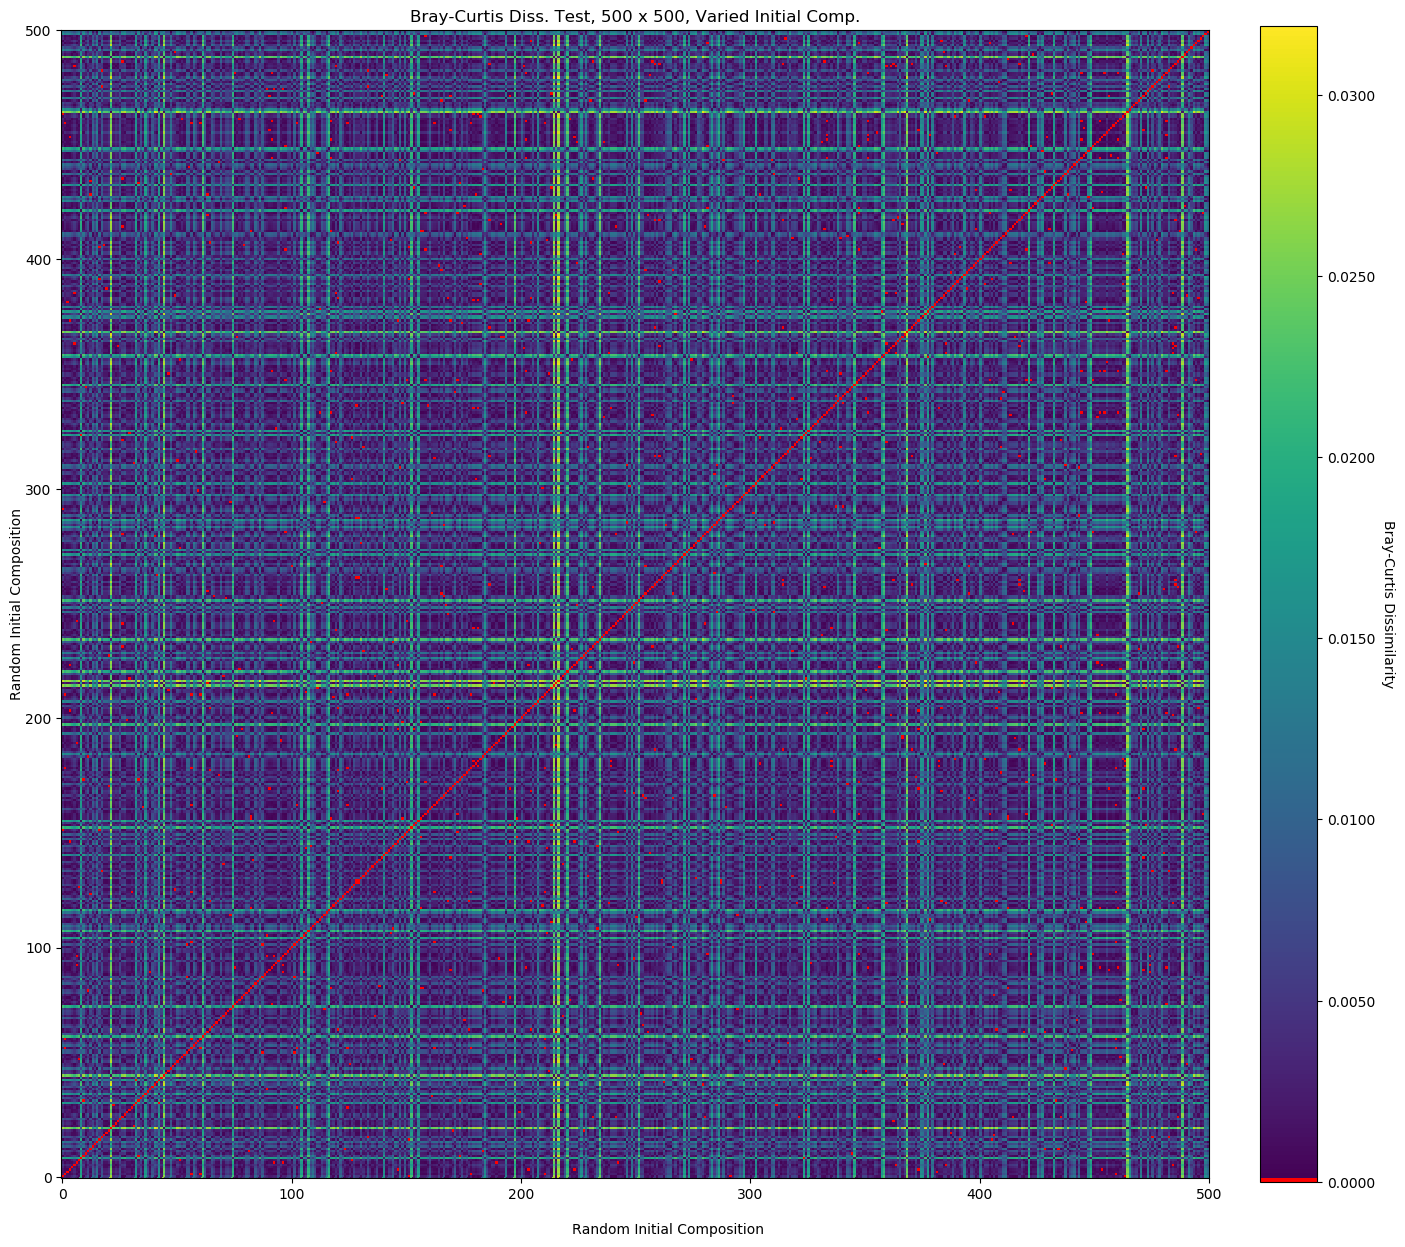

In [14]:
using PyCall
viridis = plt.cm.get_cmap("viridis", 256)
newcolors = viridis(0:255)
red = [256/256, 0/256, 0/256, 1]
newcolors[:1, :] = red
matcolors = pyimport("matplotlib.colors")
newcmp = matcolors.ListedColormap(newcolors)

fig, ax = plt.subplots()
im = ax.imshow(bcs, origin="lower", aspect="equal")
psm = ax.pcolormesh(bcs, cmap=newcmp, rasterized=true)
cbar1 = ax.figure.colorbar(psm, ax=ax, format="%0.4f", fraction=0.046, pad=0.04)
cbar1.ax.set_ylabel("Bray-Curtis Dissimilarity", rotation=-90, va="bottom")
ax.set_title("Bray-Curtis Diss. Test, $nSamples x $nSamples, Varied Initial Comp.")
fig.text(.47, 0.05, "Random Initial Composition", ha="center")
fig.text(0, .5, "Random Initial Composition", va="center", rotation="vertical")
fig.set_figheight(14)
fig.set_figwidth(14)
fig.tight_layout()
# fig.savefig("Fine_Mean_Heatmap_nC_$(nc)_nM_$(nm)_fracPos_$(convert(Int64, round(fp*100)))_normed.png", dpi=300)
# fig.savefig("Fine_Mean_Heatmap_nC_$(nc)_nM_$(nm)_fracPos_$(convert(Int64, round(fp*100)))_linear.png", dpi=300)

In [ ]:
sqrt(sum((sqrt() - sqrt(q)) ** 2)) / _SQRT2